# Image Captioning Model without Attention Mechanism

In [1]:
## Importing libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, RepeatVector, Add
from tensorflow.keras.applications import DenseNet201, MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
# Loadign the dataset
image_path = 'Images'

In [3]:
data = pd.read_csv("captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
#Read and preprocess images
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

#Display Images
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

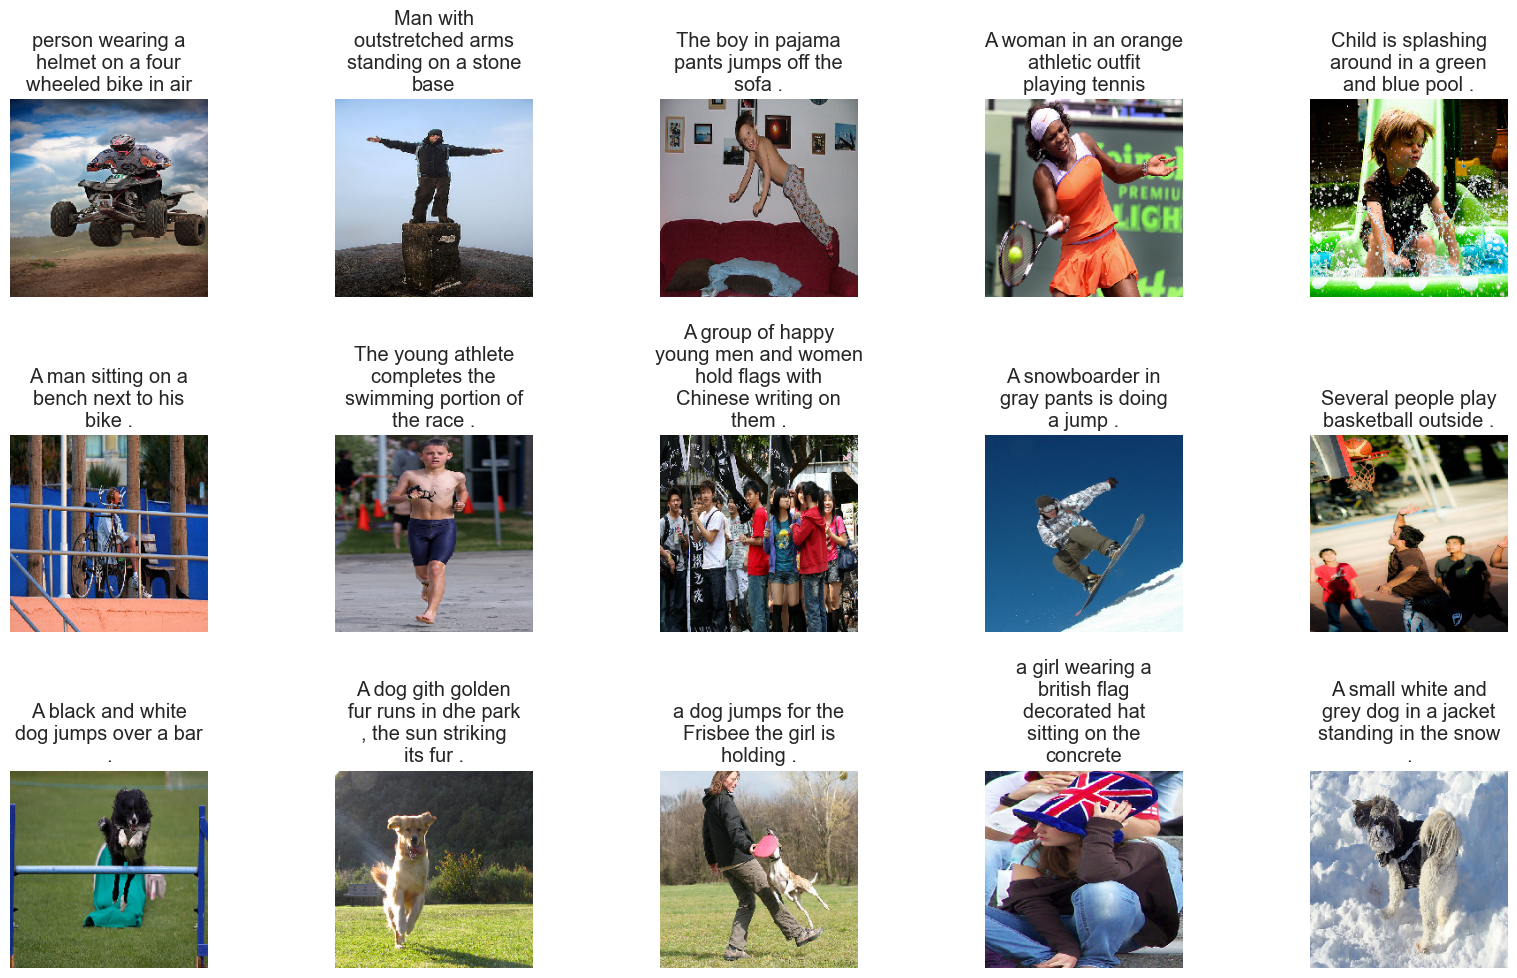

In [5]:
#Display the images
display_images(data.sample(15))

In [6]:
#Text preprocessing
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = data['caption']
    return data

## __Preprocessed Text__

In [7]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin',
 'black dog and spotted dog are fighting',
 'black dog and tri-colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [8]:
#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

#Converting text to sequences
tokenizer.texts_to_sequences([captions[1]])[0]

[16, 313, 61, 193, 114]

In [9]:
model = MobileNetV3Small()
outputs = model.layers[-2].output

fe = Model(inputs=model.input, outputs=outputs)

img_size = 512
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


import pickle

with open('features_mobilenet_v3.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('features_mobilenet_v3.pickle', 'rb') as handle:
    features = pickle.load(handle)

100%|██████████████████████████████████████████████████████████████| 8091/8091 [15:13<00:00,  8.86it/s]


In [10]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        self.indexes = np.arange(self.n)
        self.on_epoch_end()
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch = self.df.iloc[indices]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = [], [], []
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        return np.array(X1), np.array(X2), np.array(y)
    
    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [11]:

# Define input shapes
input1 = Input(shape=(1000,))
input2 = Input(shape=(32,))

# Image features processing
img_features = Dense(256, activation='relu', name='dense_img_1')(input1)
img_features = Dense(500, activation='relu', name='dense_img_2')(img_features)

# Repeat image features for sequence length
img_features_expanded = RepeatVector(32, name='repeat_vector')(img_features)

# Text features processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Concatenate image and text features
merged = concatenate([img_features_expanded, sentence_features], axis=-1)

# LSTM layer
sentence_features = LSTM(500, name='lstm')(merged)

# Apply dropout
x = Dropout(0.5)(sentence_features)

# Add image features
x = Add()([x, img_features])

# Additional dense layers
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Final dropout layer
x = Dropout(0.5)(x)

# Output layer
output = Dense(vocab_size, activation='softmax')(x)

# Create and compile the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Print model summary
caption_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 dense_img_1 (Dense)            (None, 256)          256256      ['input_2[0][0]']                
                                                                                                  
 dense_img_2 (Dense)            (None, 500)          128500      ['dense_img_1[0][0]']            
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                            

In [12]:
from tensorflow.keras.utils import plot_model

In [13]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 dense_img_1 (Dense)            (None, 256)          256256      ['input_2[0][0]']                
                                                                                                  
 dense_img_2 (Dense)            (None, 500)          128500      ['dense_img_1[0][0]']            
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                            

In [15]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [16]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True, mode="min")

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2,
                                            min_lr=1e-9)

In [17]:
caption_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [18]:
# Training the model
history = caption_model.fit(
        train_generator,
        epochs=400,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/400
537/537 [==============================] - ETA: 0s - loss: 6.3749
Epoch 1: val_loss improved from inf to 5.82591, saving model to model.h5
537/537 [==============================] - 249s 458ms/step - loss: 6.3749 - val_loss: 5.8259 - lr: 1.0000e-04
Epoch 2/400
537/537 [==============================] - ETA: 0s - loss: 5.7177
Epoch 2: val_loss improved from 5.82591 to 5.37510, saving model to model.h5
537/537 [==============================] - 296s 552ms/step - loss: 5.7177 - val_loss: 5.3751 - lr: 1.0000e-04
Epoch 3/400
537/537 [==============================] - ETA: 0s - loss: 5.2840
Epoch 3: val_loss improved from 5.37510 to 5.04695, saving model to model.h5
537/537 [==============================] - 264s 492ms/step - loss: 5.2840 - val_loss: 5.0470 - lr: 1.0000e-04
Epoch 4/400
537/537 [==============================] - ETA: 0s - loss: 4.9849
Epoch 4: val_loss improved from 5.04695 to 4.80762, saving model to model.h5
537/537 [==============================] - 365s 679ms/

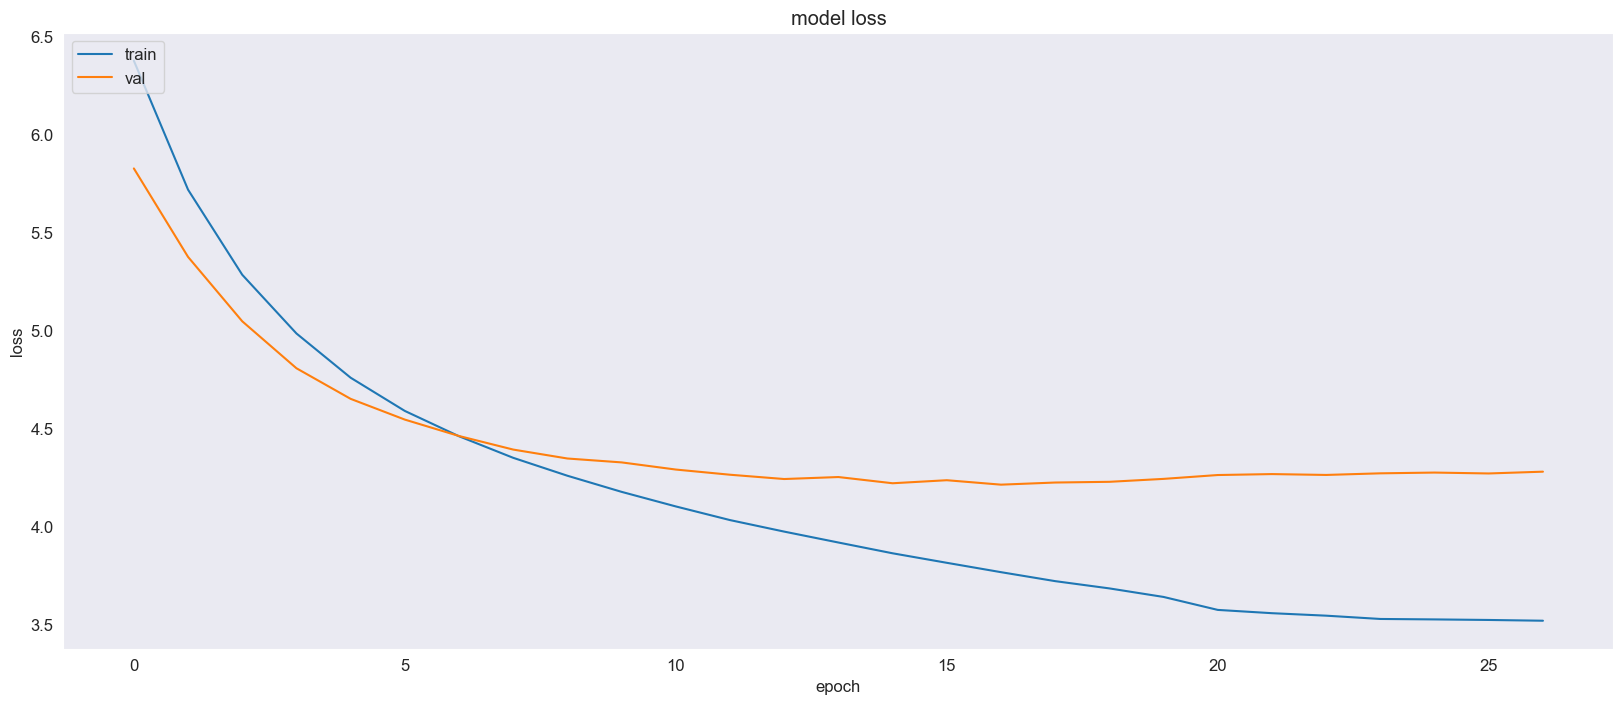

In [19]:
# Plot the training and validation loss
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [21]:
#Predicting Captions
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = ""
    for i in range(int(max_length/3.5)):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [22]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [23]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 20ms/step


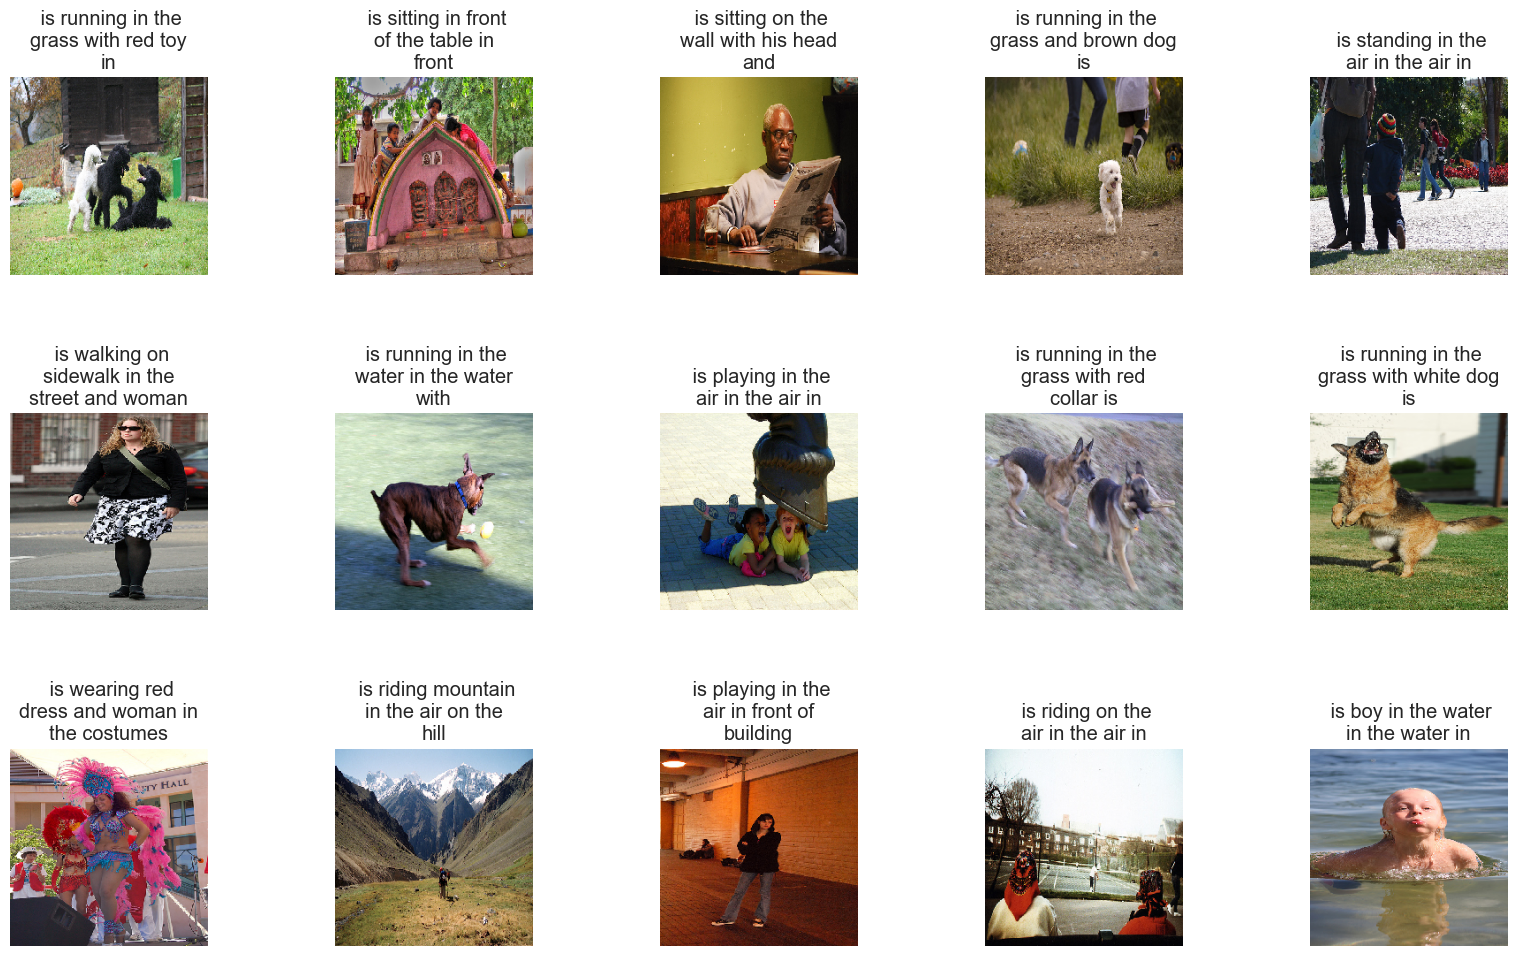

In [24]:
#Display images with predicted captions
display_images(samples)